# By: Thomas Isola
## Class: PUI 2018
## HW #7
Please note: Place a text file with your API key as per the instructions in Part 2.1 below

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import json
import urllib.request as urllib
import shutil
import requests
import io
import zipfile
import shapely
from fiona.crs import from_epsg
import numpy as np
import pylab as pl
%matplotlib inline

In [2]:
# Check if PUIdata exists
import os
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/ti582/PUIdata


# Part 1

## Part 1.1

In [3]:
# Download the PUMA data
PUMAurl = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=GeoJSON'
urllib.urlretrieve(PUMAurl,"file.geojson")
# Convert the data to a GeoDataFrame
PUMAdata = gpd.GeoDataFrame.from_file('file.geojson')
PUMAdata.head()

,puma,shape_area,shape_leng,geometry
0,3701,97928517.7258,53227.1444612,(POLYGON ((-73.89641133483133 40.9045045208202...
1,3702,188986042.978,106050.002302,(POLYGON ((-73.8442314689986 40.86942035096838...
2,3703,267013740.076,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,106212853.306,47970.9012768,(POLYGON ((-73.84792614069238 40.8713422330779...
4,4015,81054382.1573,50007.4154926,(POLYGON ((-73.95374853778468 40.6385863375854...


In [4]:
# Move the data to the PUIDATA folder
currentPath = os.getcwd()
newPath = os.getenv('PUIDATA')
shutil.move('%s/file.geojson'%currentPath, '%s/file.geojson'%newPath)

'/nfshome/ti582/PUIdata/file.geojson'

In [5]:
# Check if the data is in the PUIDATA directory
!ls $PUIDATA

201501-citibike-tripdata.csv  aff_download
201501-citibike-tripdata.zip  aff_download.zip
201602-citibike-tripdata.csv  busData.txt
201602-citibike-tripdata.zip  file.geojson
201608-citibike-tripdata.csv  PLUTO_for_WEB
201608-citibike-tripdata.zip  Traffic_Volume_Counts_2012-2013.csv


## Part 1.2

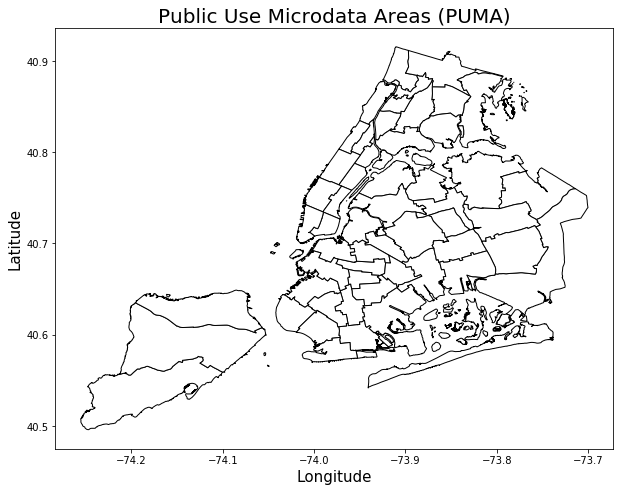

In [6]:
# Plot the PUMA data
thePlot = PUMAdata.plot(figsize=(10,10),edgecolor='black',facecolor='w')
thePlot.set_title('Public Use Microdata Areas (PUMA)',fontsize=20);
thePlot.set_xlabel('Longitude',fontsize=15);
thePlot.set_ylabel('Latitude',fontsize=15);

**Figure 1**: The above figure represents the Public Use Microdata Areas (PUMA), comprising a minimum population of 100,000 people, which can be used used for studying American Community Survey (ACS) estimates.

# Part 2

## Part 2.1

In [7]:
# I have created a python file, 'censusAPI.py', which has a function called myAPI.
# That function takes one argument, which is the name of a text file.
# In order to ensure compatability with my notebook, please name your text file 'censusTextFile.txt'.
# I have purposely not uploaded my 'censusTextFile.txt' file because it has my API key in it.
# The contents of your 'censusTextFile.txt' file should be your own census API key.
# The code below reads your API key from the text file.
from censusAPI import myAPI
censusAPIkey = myAPI('censusTextFile');

In [8]:
# Read in the ACS data
ACSurl = "https://api.census.gov/data/2016/acs/acs1/variables.json"
ACSresp = requests.request('GET', ACSurl)
aff1y = json.loads(ACSresp.text)

In [9]:
# Convert data into an array
affkeys = np.array(list(aff1y['variables'].keys()))

In [10]:
# Extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") 
 and "Broadband" in aff1y['variables'][k]['label']]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription')]

In [11]:
# Keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [12]:
# Keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [13]:
# Get the broadband access number of households
CENSUSurl = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + censusAPIkey
CENSUSresp = requests.request('GET', CENSUSurl).content
pumaBB = pd.read_csv(io.StringIO(CENSUSresp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [14]:
# Get the first row of the table: the total number of households
keyNPP = 'B28002_001E'
CENSUSurl2 = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNPP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + censusAPIkey
CENSUSresp2 = requests.request('GET', CENSUSurl2).content
pumaPP = pd.read_csv(io.StringIO(CENSUSresp2.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## Part 2.2

In [15]:
# Generate a new column that shows the percentage of households with broadband access
pumaBB['pcBB'] = (pumaBB['B28002_004E']/pumaPP['B28002_001E'])*100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,78.150656


## Part 2.3

In [16]:
# Unzip the contents of the file, which was manually downloaded to PUIdata as per the HW instructions
zip_ref = zipfile.ZipFile(os.getenv("PUIDATA") + "/aff_download.zip", 'r')
zip_ref.extractall(os.getenv("PUIDATA") + "/aff_download")
zip_ref.close()

# Create a pandas dataframe
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/aff_download" + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [17]:
# Drop the 0 index row and convert the resulting GCT_STUB.target-geo-id2 column into integers
# and the HC01 column into float
bbpc.drop(0, inplace=True)
bbpc[['GCT_STUB.target-geo-id2']] = bbpc[['GCT_STUB.target-geo-id2']].astype(int)
bbpc[['HC01']] = bbpc[['HC01']].astype(float)

In [18]:
# Rename the columns and filter the data
bbpc = bbpc.rename(index=str, columns={"GCT_STUB.target-geo-id2": "gid", "HC01": "HC01", "HC02": "HC02"})
bbpc = bbpc.loc[(bbpc['gid']>=3600000) & (bbpc['gid']<5700000)]

In [19]:
# Perform subtraction to manipulate the 'gid' column in preparation for mergin
bbpc.gid=bbpc.gid-3600000

In [20]:
# Merge the dataframes and describe the difference
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"])

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


# Part 3

In [21]:
# Merge dataframes in preparation for plotting
pumaBB2 = pumaBB.rename(index=str, columns={"B28002_004E": "B28002_004E", "NAME": "NAME", "state": "state",
                                            "public use microdata area": "pumaID","Unnamed: 4": "Unnamed: 4",
                                            "pcBB": "pcBB"})
NYCpuma = PUMAdata.puma.values
NYCpuma = NYCpuma.astype(int)
pumaBB3 = pumaBB2.loc[pumaBB2.pumaID.isin(NYCpuma) == True]

PUMAdata[['puma']] = PUMAdata[['puma']].astype(int)
PUMAdata2 = PUMAdata.merge(pumaBB3, right_on="pumaID", 
                     left_on="puma")

## Part 3.1

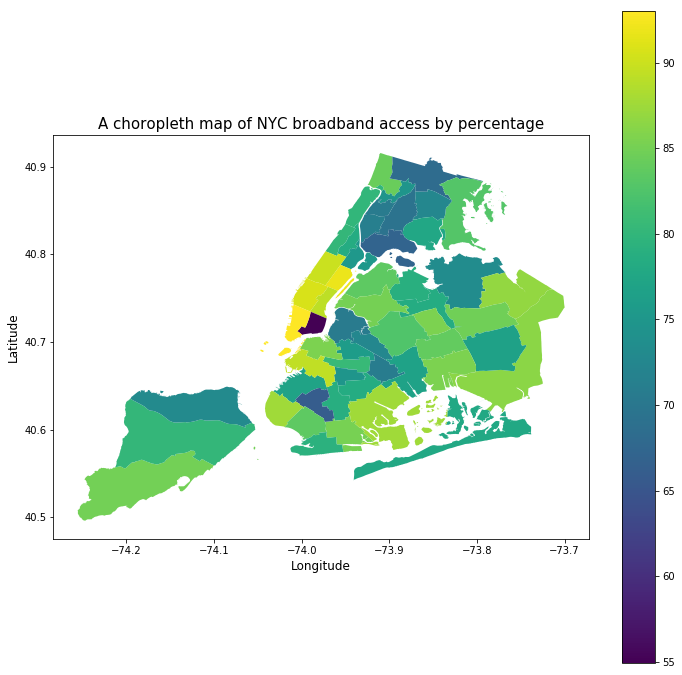

In [22]:
# Plot the choropleth of NYC broadband access
thePlot31 = PUMAdata2.plot(column='pcBB',figsize=(12,12),cmap='viridis',alpha=1,
                          linewidth=0.1,legend=True,k=10)
thePlot31.set_title('A choropleth map of NYC broadband access by percentage',fontsize=15);
thePlot31.set_xlabel('Longitude',fontsize=12);
thePlot31.set_ylabel('Latitude',fontsize=12);

**Figure 2**: The above figure shows a choropleth map of the percentage of broadband access in NYC. The lower end of the spectrum is around 50% and the upper end is around 100%. Most of NYC is around 80-90%, however, in the bottom east portion of Manhattan, the internet access is on the low end of the spectrum around 50%, which is peculiar. Even more peculiar is that to the west of there, in the bottom west portion of Manhattan, the internet access is on the high end of the spectrum around 100%.  
  
Another thing to note is that Manhattan generally has greater broadband access compared to the other boroughs.

# Part 4

In [23]:
# Load in linkNYC data from Professor Bianco's GitHub repository
linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv')
linkNYC = linkNYC.drop(['Unnamed: 0'], axis=1)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [24]:
# Convert latitude and longitude of linkNYC dataframe in preparation to converting to a GeoDataFrame
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [25]:
linkNYC = linkNYC.drop(['longitude','latitude'], axis=1)
crs = {'init': 'epsg:4326'}
linkNYCgdf = gpd.GeoDataFrame(linkNYC,crs=crs)

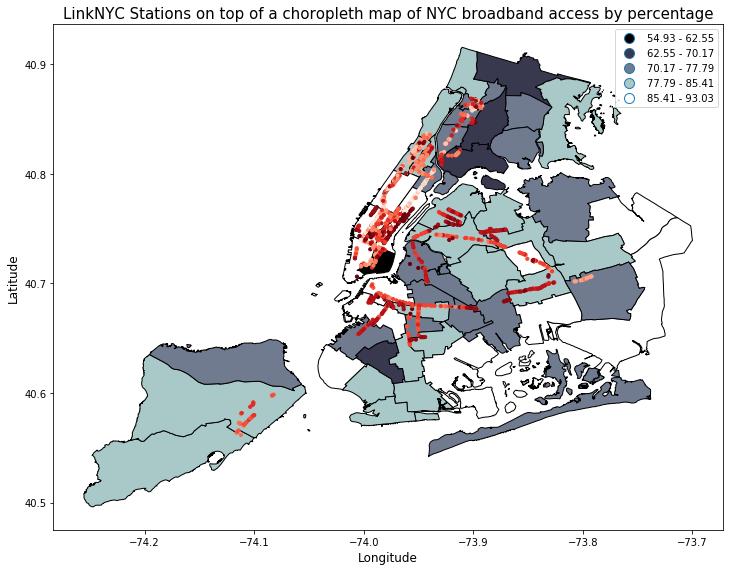

In [26]:
# Plot the data
plot4 = PUMAdata2.plot(column='pcBB',figsize=(12,12),cmap='bone',alpha=1,edgecolor='black',
                          legend=True,scheme='equal_interval',k=5);
linkNYCgdf.plot(column='date_link_',ax=plot4,cmap='Reds',marker='o',markersize=10);
plot4.set_title('LinkNYC Stations on top of a choropleth map of NYC broadband access by percentage',fontsize=15);
plot4.set_xlabel('Longitude',fontsize=12);
plot4.set_ylabel('Latitude',fontsize=12);

**Figure 3**: The above map shows a choropleth map as described in the caption for Figure 2. Additionally, the locations of the linkNYC stations are shown. As can be seen, the majority of the stations are located in Manhattan, Brooklyn, and Queens.

# Part 5

## Part 5.1

In [27]:
# Get the total population by PUMA
keyPOP = 'B00001_001E'
CENSUSurl3 = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPOP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + censusAPIkey
CENSUSresp3 = requests.request('GET', CENSUSurl3).content
pumaPop = pd.read_csv(io.StringIO(CENSUSresp3.decode('utf-8').replace('[','').replace(']','')))
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## Part 5.2

In [28]:
# 1. Convert PUMAdata and linkNYC to epsg 2263
# 2. Spatial join the linkNYC and PUMAdata
# 3. Group by linkNYC count per PUMA area
linkNYCgdf.to_crs(epsg=2263)
PUMAdata2.to_crs(epsg=2263)
linkppA = gpd.sjoin(linkNYCgdf,PUMAdata2)
linkppB = linkppA.groupby(['pumaID'])
linkppB = linkppB.count()
linkpp = linkppB.drop(['date_link_','lonlat','geometry','index_right','puma','shape_area','shape_leng','B28002_004E','NAME','state','Unnamed: 4','pcBB'], axis=1)
linkpp.head()

,link_site
pumaID,
3701,1
3705,1
3706,20
3707,29
3708,19


In [29]:
# Clean up PUMAdata2 and linkpp dataframe
PUMAdata3 = PUMAdata2.drop(['puma','B28002_004E','Unnamed: 4'], axis=1)
linkpp = linkpp.rename(index=str, columns={"pumaID": "pumaID", "link_site": "LinkNYCstationsCount"})
linkpp['pumaID2']=linkpp.index
linkpp[['pumaID2']]=linkpp[['pumaID2']].astype(int)

In [30]:
# Manipulate linkpp dataframe to include puma areas that have no linkNYC stations
pumaComparison = PUMAdata3.pumaID.values
L = list(set(pumaComparison) - set(linkpp.pumaID2.values))
linkpp_formerging = pd.DataFrame({'pumaID2':L})
linkpp_formerging['LinkNYCstationsCount']=[0]*18
linkpp2 = pd.concat([linkpp, linkpp_formerging], ignore_index=True)

In [31]:
# 1. Merge linkpp2 into PUMAdata3
# 2. Filter pumaPop dataframe to only include NYC
# 3. Add pumaPop population column to PUMAdata
PUMAdata4 = PUMAdata3.merge(linkpp2, right_on="pumaID2", left_on="pumaID")
pumaPop2 = pumaPop.rename(index=str, columns={"B00001_001E": "B00001_001E", "NAME": "NAME", "state": "state",
                                            "public use microdata area": "pumaID","Unnamed: 4": "Unnamed: 4"})
pumaPop3 = pumaPop2.loc[pumaPop2.pumaID.isin(NYCpuma) == True]
PUMAdata4 = PUMAdata4.sort_values('pumaID',ascending=True)
PUMAdata4['B00001_001E'] = pumaPop3.B00001_001E.values
PUMAdata4['linkNYCp100p'] = (PUMAdata4.LinkNYCstationsCount*100)/PUMAdata4.B00001_001E
PUMAdata4['linkNYCp100p'].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

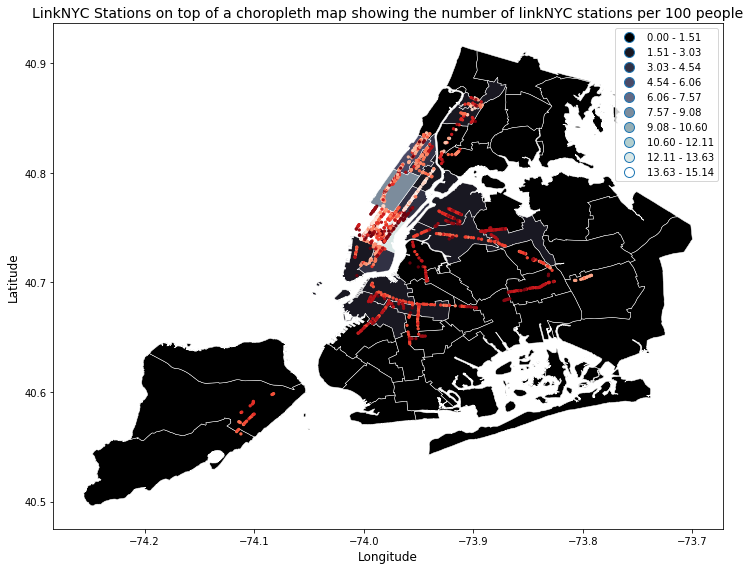

In [32]:
# Plot the data
plot52 = PUMAdata4.plot(column='linkNYCp100p',figsize=(12,12),cmap='bone',alpha=1,edgecolor='white',
                          linewidth=0.5,legend=True,scheme='equal_interval',k=10);
linkNYCgdf.plot(column='date_link_',ax=plot52,cmap='Reds',marker='o',markersize=5);
plot52.set_title('LinkNYC Stations on top of a choropleth map showing the number of linkNYC stations per 100 people',fontsize=14);
plot52.set_xlabel('Longitude',fontsize=12);
plot52.set_ylabel('Latitude',fontsize=12);

**Figure 4**: The figure above shows a choropleth map of the number of linkNYC stations per 100 people for each PUMA area in New York City. Also plotted on the figure are the locations of the linkNYC stations in New York City. There are a few things to note in the figure. First, it is evident that the highest density of linkNYC stations per 100 people is located in Manhattan. The other boroughs have a lower density. As was seen in **Figure 2** and **Figure 3**, Manhattan has greater broadband access compared to the other boroughs, therefore, it may be beneficial to increase the density of linkNYC stations per 100 people in the other boroughs (excluding Manhattan), where the stations would have a greater impact due to the decreased broadband access.